# TPE Hyperparameter Optimization of CNN - Hyperopt

In this notebook, we will use **TPE driven Bayesian Optimization** to select the best **hyperparameters** for a CNN that recognizes digits in images, using the MNIST dataset and the open source Python package [Hyperopt](http://hyperopt.github.io/hyperopt/).

The MNIST dataset is availale in [Kaggle](https://www.kaggle.com/c/digit-recognizer/data).


## Download dataset

- Navigate to the [MNIST website in Kaggle](https://www.kaggle.com/c/digit-recognizer/data)
- Download the train.csv file
- Unzip and copy the train.csv file to where you see the SAVE_DATASETS-HERE.txt file
- Rename to mnist.csv

**Remember that you need to be logged in to be able to download the dataset**

## Notebook content

- Data Preparation
- Set up the hyperparameter search shape
- Set up a simple CNN
- Set up the objective function
- Perform Bayesian Optimization
- Evaluate Model Performance

In [1]:
# For reproducible results.
# See: 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [2]:
import itertools
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [4]:
from hyperopt import hp, tpe, fmin, Trials

#  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [5]:
# Load the data

data = pd.read_csv("../mnist.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

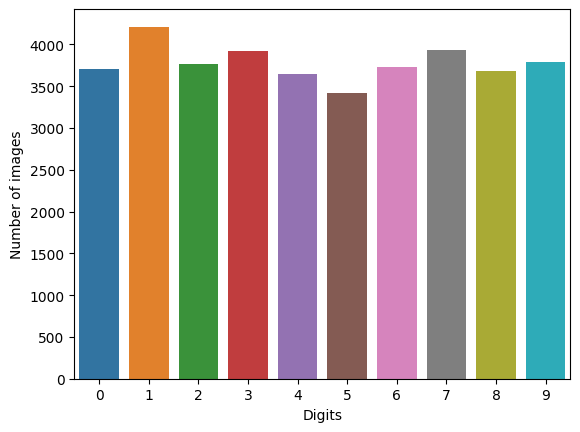

In [7]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

## Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [8]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [9]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

## Target encoding

In [10]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1], dtype=int64)

In [11]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's print some example images.

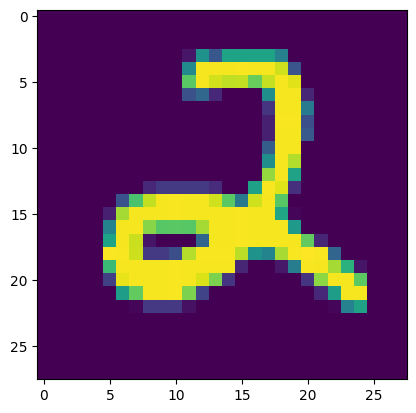

In [12]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

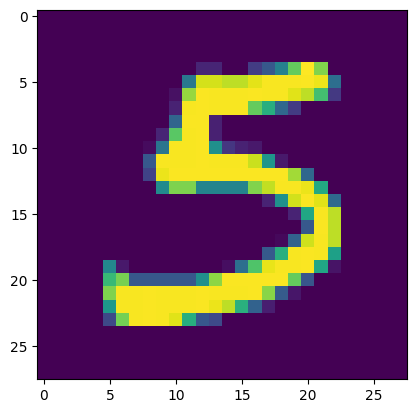

In [13]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

# Define the Hyperparameter Space

Hyperopt provides the hp module to create distributions to sample the hyperparameters. More details in [Defining a Search Space](http://hyperopt.github.io/hyperopt/getting-started/search_spaces/).


We want to find the following hyper-parameters:

- The learning rate of the optimizer.
- The number of convolutional layers.
- The number of fully-connected Dense layers.
- The number of nodes (neurons) for each of the dense layers.
- Whether to use 'sigmoid' or 'relu' activation in all the layers.

In [14]:
# determine the hyperparameter space

param_grid = {
    'learning_rate': hp.uniform('learning_rate', 1e-6, 1e-2),
    'num_conv_layers': hp.quniform('num_conv_layers', 1, 3, 1),
    'num_dense_layers': hp.quniform('num_dense_layers', 1, 5, 1),
    'num_dense_nodes': hp.quniform('num_dense_nodes', 5, 512, 1),
    'activation': hp.choice('activation', ['relu', 'sigmoid']),
}

# Define the CNN

We will create a CNN, with 2 Convolutional layers followed by Pooling, and varying number of fully-connected Dense layers. Each Convlutional layer, can itself have more than 1 conv layer.

In [15]:
# function to create the CNN

def create_cnn(
    # the hyperparam to optimize are passed
    # as arguments
    learning_rate,
    num_conv_layers,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    """
    Hyper-parameters:
    learning_rate:        Learning-rate for the optimizer.
    convolutional layers: Number of conv layers.
    num_dense_layers:     Number of dense layers.
    num_dense_nodes:      Number of nodes in each dense layer.
    activation:           Activation function for all layers.
    """

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # First convolutional layer.
    # There are many hyper-parameters in this layer
    # For this demo, we will optimize the activation function and
    # the number of convolutional layers that it can take.
    
    # We add the different number of conv layers in the following loop:
    
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                         activation=activation))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Same hyperparameters to optimize as previous layer.
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                         activation=activation))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:
    
    for i in range(num_dense_layers):
        
        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(lr=learning_rate)

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define the Objective Function

In [16]:
# we will save the model with this name
path_best_model = 'cnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [17]:
def objective(params):
    
    """
    Hyper-parameters:
    learning_rate:        Learning-rate for the optimizer.
    convolutional layers: Number of conv layers.
    num_dense_layers:     Number of dense layers.
    num_dense_nodes:      Number of nodes in each dense layer.
    activation:           Activation function for all layers.
    """

    # Print the hyper-parameters.        
    print('learning rate: ', params['learning_rate'])
    print('num_conv_layers: ', int(params['num_conv_layers']))
    print('num_dense_layers: ',int(params['num_dense_layers']))
    print('num_dense_nodes: ', int(params['num_dense_nodes']))
    print('activation: ', params['activation'])
    print()
    
    # Create the neural network with the hyper-parameters.
    # We call the function we created previously.
    model = create_cnn(learning_rate=params['learning_rate'],
                       num_conv_layers=int(params['num_conv_layers']),
                       num_dense_layers=int(params['num_dense_layers']),
                       num_dense_nodes=int(params['num_dense_nodes']),
                       activation=params['activation'],
                       )

   
    # Set a learning rate annealer
    # this reduces the learning rate if learning does not improve
    # for a certain number of epochs
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
   
    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=3,
                        batch_size=128,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    
    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return -accuracy

## Test run

In [18]:
# Before we run the hyper-parameter optimization,
# let's first check that the everything is working
# by passing some default hyper-parameters.

default_parameters = {
    'learning_rate': 1e-5,
    'num_conv_layers': 1,
    'num_dense_layers': 1,
    'num_dense_nodes': 16,
    'activation': 'relu',
}


objective(default_parameters)

learning rate:  1e-05
num_conv_layers:  1
num_dense_layers:  1
num_dense_nodes:  16
activation:  relu



C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 16s 58ms/step - loss: 2.2550 - accuracy: 0.2305 - val_loss: 2.2069 - val_accuracy: 0.3574 - lr: 1.0000e-05
Epoch 2/3
266/266 [==============================] - 15s 55ms/step - loss: 2.1454 - accuracy: 0.4382 - val_loss: 2.0715 - val_accuracy: 0.4889 - lr: 1.0000e-05
Epoch 3/3
266/266 [==============================] - 15s 56ms/step - loss: 1.9734 - accuracy: 0.5085 - val_loss: 1.8640 - val_accuracy: 0.5169 - lr: 1.0000e-05

Accuracy: 51.69%



-0.5169312357902527

We obtained a mediocre accuracy, but all our code is working. So let's get started with the Optimization now!!

## Bayesian Optimization with TPE

In [ ]:
# fmin performs the minimization
# tpe.suggest samples the parameters following tpe

# with default parameters for TPE
trials = Trials()

search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=30,
    rstate=np.random.default_rng(42),
    algo=tpe.suggest,  # tpe
    trials=trials
)

learning rate:                                                                                                         
0.006517772255089191                                                                                                   
num_conv_layers:                                                                                                       
3                                                                                                                      
num_dense_layers:                                                                                                      
3                                                                                                                      
num_dense_nodes:                                                                                                       
418                                                                                                                    
activation:                             

C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)



 68/266 [======>.......................] - ETA: 1:17 - loss: 2.3694 - accuracy: 0.1086                                


136/266 [==============>...............] - ETA: 51s - loss: 2.3358 - accuracy: 0.1102                                  


204/266 [======================>.......] - ETA: 24s - loss: 2.3246 - accuracy: 0.1074                                  


266/266 [==============================] - 109s 408ms/step - loss: 2.3195 - accuracy: 0.1056 - val_loss: 2.3017 - val_accuracy: 0.1146 - lr: 0.0065

Epoch 2/3                                                                                                              

  4/266 [..............................] - ETA: 1:54 - loss: 2.3002 - accuracy: 0.1035                                


 72/266 [=======>......................] - ETA: 1:15 - loss: 2.3019 - accuracy: 0.1042                                


140/266 [==============>...............] - ETA: 49s - loss: 2.3020 - accuracy: 0.1063                                  


208/266 [======================>.......] - ETA: 22s - loss: 2.3019 - accuracy: 0.1069                                  


266/266 [==============================] - 104s 390ms/step - loss: 2.3018 - accuracy: 0.1088 - val_loss: 2.3006 - val_accuracy: 0.1146 - lr: 0.0065

Epoch 3/3                                                                                                              

  8/266 [..............................] - ETA: 1:38 - loss: 2.2981 - accuracy: 0.1270                                


 76/266 [=======>......................] - ETA: 1:10 - loss: 2.3013 - accuracy: 0.1127                                


144/266 [===============>..............] - ETA: 46s - loss: 2.3011 - accuracy: 0.1136                                  


212/266 [======================>.......] - ETA: 20s - loss: 2.3013 - accuracy: 0.1120                                  


266/266 [==============================] - ETA: 0s - loss: 2.3016 - accuracy: 0.1111                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0032588860485702753.

266/266 [==============================] - 103s 387ms/step - loss: 2.3016 - accuracy: 0.1111 - val_loss: 2.3016 - val_accuracy: 0.1146 - lr: 0.0065

Accuracy: 11.46%                                                                                                       
learning rate:                                                                                                         
0.000600301954624924                                                                                                   
num_conv_layers:                                                                                                       
3                                                      

Epoch 1/3                                                                                                              

 67/266 [======>.......................] - ETA: 1:15 - loss: 2.3192 - accuracy: 0.1046                                


135/266 [==============>...............] - ETA: 54s - loss: 2.3130 - accuracy: 0.1063                                  


203/266 [=====================>........] - ETA: 26s - loss: 2.3102 - accuracy: 0.1059                                  


266/266 [==============================] - 116s 430ms/step - loss: 2.3100 - accuracy: 0.1060 - val_loss: 2.3041 - val_accuracy: 0.1146 - lr: 6.0030e-04

Epoch 2/3                                                                                                              

  3/266 [..............................] - ETA: 2:05 - loss: 2.2982 - accuracy: 0.1016                                


 71/266 [=======>......................] - ETA: 1:24 - loss: 2.3071 - accuracy: 0.1028                                


139/266 [==============>...............] - ETA: 57s - loss: 2.3075 - accuracy: 0.1006                                  


207/266 [======================>.......] - ETA: 27s - loss: 2.3075 - accuracy: 0.1024                                  


266/266 [==============================] - 127s 479ms/step - loss: 2.3072 - accuracy: 0.1045 - val_loss: 2.3064 - val_accuracy: 0.0937 - lr: 6.0030e-04

Epoch 3/3                                                                                                              

  7/266 [..............................] - ETA: 2:16 - loss: 2.3050 - accuracy: 0.1038                                


 75/266 [=======>......................] - ETA: 1:38 - loss: 2.3059 - accuracy: 0.1064                                


143/266 [===============>..............] - ETA: 58s - loss: 2.3055 - accuracy: 0.1058                                  


211/266 [======================>.......] - ETA: 25s - loss: 2.3052 - accuracy: 0.1047                                  


266/266 [==============================] - ETA: 0s - loss: 2.3056 - accuracy: 0.1039                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00030015097581781447.

266/266 [==============================] - 124s 465ms/step - loss: 2.3056 - accuracy: 0.1039 - val_loss: 2.3093 - val_accuracy: 0.0868 - lr: 6.0030e-04

Accuracy: 8.68%                                                                                                        
learning rate:                                                                                                         
0.0015726398259184094                                                                                                  
num_conv_layers:                                                                                                       
2                                                 

sigmoid                                                                                                                
Epoch 1/3                                                                                                              

 66/266 [======>.......................] - ETA: 45s - loss: 2.3364 - accuracy: 0.1082                                  


134/266 [==============>...............] - ETA: 29s - loss: 2.3222 - accuracy: 0.1058                                  


202/266 [=====================>........] - ETA: 14s - loss: 2.3176 - accuracy: 0.1054                                  


266/266 [==============================] - 67s 248ms/step - loss: 2.3156 - accuracy: 0.1044 - val_loss: 2.3065 - val_accuracy: 0.1146 - lr: 0.0016

Epoch 2/3                                                                                                              

  2/266 [..............................] - ETA: 1:04 - loss: 2.3045 - accuracy: 0.1055                                


 70/266 [======>.......................] - ETA: 48s - loss: 2.3074 - accuracy: 0.1004                                  


138/266 [==============>...............] - ETA: 31s - loss: 2.3070 - accuracy: 0.1008                                  


206/266 [======================>.......] - ETA: 15s - loss: 2.3065 - accuracy: 0.1026                                  


266/266 [==============================] - 69s 259ms/step - loss: 2.3060 - accuracy: 0.1044 - val_loss: 2.3039 - val_accuracy: 0.1146 - lr: 0.0016

Epoch 3/3                                                                                                              

  6/266 [..............................] - ETA: 1:14 - loss: 2.3011 - accuracy: 0.1211                                


 74/266 [=======>......................] - ETA: 46s - loss: 2.3038 - accuracy: 0.1111                                  


142/266 [===============>..............] - ETA: 29s - loss: 2.3035 - accuracy: 0.1088                                  


210/266 [======================>.......] - ETA: 13s - loss: 2.3034 - accuracy: 0.1064                                  


266/266 [==============================] - ETA: 0s - loss: 2.3037 - accuracy: 0.1055                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0007863198989070952.

266/266 [==============================] - 66s 248ms/step - loss: 2.3037 - accuracy: 0.1055 - val_loss: 2.3044 - val_accuracy: 0.1079 - lr: 0.0016

Accuracy: 10.79%                                                                                                       
learning rate:                                                                                                         
0.007044895702734193                                                                                                   
num_conv_layers:                                                                                                       
2                                                       

activation:                                                                                                            
sigmoid                                                                                                                
Epoch 1/3                                                                                                              

 65/266 [======>.......................] - ETA: 50s - loss: 2.3681 - accuracy: 0.1031                                  


133/266 [==============>...............] - ETA: 33s - loss: 2.3380 - accuracy: 0.1028                                  


201/266 [=====================>........] - ETA: 16s - loss: 2.3276 - accuracy: 0.1036                                  


266/266 [==============================] - 68s 251ms/step - loss: 2.3235 - accuracy: 0.1046 - val_loss: 2.3059 - val_accuracy: 0.1146 - lr: 0.0070

Epoch 2/3                                                                                                              

  1/266 [..............................] - ETA: 1:07 - loss: 2.3026 - accuracy: 0.1172                                 


 69/266 [======>.......................] - ETA: 51s - loss: 2.3095 - accuracy: 0.1011                                  


137/266 [==============>...............] - ETA: 32s - loss: 2.3097 - accuracy: 0.1020                                  


205/266 [======================>.......] - ETA: 15s - loss: 2.3096 - accuracy: 0.1036                                  


266/266 [==============================] - 68s 255ms/step - loss: 2.3095 - accuracy: 0.1035 - val_loss: 2.3105 - val_accuracy: 0.0937 - lr: 0.0070

Epoch 3/3                                                                                                              

  5/266 [..............................] - ETA: 1:08 - loss: 2.3058 - accuracy: 0.0984                                


 73/266 [=======>......................] - ETA: 46s - loss: 2.3083 - accuracy: 0.1056                                  


141/266 [==============>...............] - ETA: 29s - loss: 2.3076 - accuracy: 0.1055                                  


209/266 [======================>.......] - ETA: 13s - loss: 2.3074 - accuracy: 0.1055                                  


266/266 [==============================] - ETA: 0s - loss: 2.3079 - accuracy: 0.1046                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0035224477760493755.

266/266 [==============================] - 62s 233ms/step - loss: 2.3079 - accuracy: 0.1046 - val_loss: 2.3126 - val_accuracy: 0.0960 - lr: 0.0070

Accuracy: 9.60%                                                                                                        
learning rate:                                                                                                         
0.003461839857747386                                                                                                   
num_conv_layers:                                                                                                       
2                                                       

260                                                                                                                    
activation:                                                                                                            
relu                                                                                                                   
Epoch 1/3                                                                                                              

 64/266 [======>.......................] - ETA: 43s - loss: 0.4466 - accuracy: 0.8518                                  


132/266 [=============>................] - ETA: 29s - loss: 0.2671 - accuracy: 0.9134                                  


200/266 [=====================>........] - ETA: 14s - loss: 0.2032 - accuracy: 0.9345                                  


266/266 [==============================] - 60s 223ms/step - loss: 0.1701 - accuracy: 0.9453 - val_loss: 0.0791 - val_accuracy: 0.9780 - lr: 0.0035

Epoch 2/3                                                                                                              



 68/266 [======>.......................] - ETA: 44s - loss: 0.0452 - accuracy: 0.9852                                  


136/266 [==============>...............] - ETA: 28s - loss: 0.0536 - accuracy: 0.9827                                  


204/266 [======================>.......] - ETA: 13s - loss: 0.0549 - accuracy: 0.9827                                  


266/266 [==============================] - 59s 222ms/step - loss: 0.0524 - accuracy: 0.9838 - val_loss: 0.0619 - val_accuracy: 0.9828 - lr: 0.0035

Epoch 3/3                                                                                                              

  4/266 [..............................] - ETA: 55s - loss: 0.0247 - accuracy: 0.9922                                  


 72/266 [=======>......................] - ETA: 46s - loss: 0.0299 - accuracy: 0.9908                                  


140/266 [==============>...............] - ETA: 31s - loss: 0.0319 - accuracy: 0.9903                                  


208/266 [======================>.......] - ETA: 14s - loss: 0.0322 - accuracy: 0.9903                                  


266/266 [==============================] - 66s 248ms/step - loss: 0.0320 - accuracy: 0.9905 - val_loss: 0.0634 - val_accuracy: 0.9841 - lr: 0.0035

Accuracy: 98.41%                                                                                                       
learning rate:                                                                                                         
0.007231756096517844                                                                                                   
num_conv_layers:                                                                                                       
2                                                                                                                      
num_dense_layers:                                                                                                      
2                                                                                                                      
num_dense_no

activation:                                                                                                            
relu                                                                                                                   
Epoch 1/3                                                                                                              

 65/266 [======>.......................] - ETA: 49s - loss: 2.3087 - accuracy: 0.1076                                  


133/266 [==============>...............] - ETA: 32s - loss: 2.3056 - accuracy: 0.1097                                  


201/266 [=====================>........] - ETA: 15s - loss: 2.3043 - accuracy: 0.1088                                  


266/266 [==============================] - 67s 249ms/step - loss: 2.3038 - accuracy: 0.1071 - val_loss: 2.3022 - val_accuracy: 0.1146 - lr: 0.0072

Epoch 2/3                                                                                                              

  1/266 [..............................] - ETA: 1:06 - loss: 2.2988 - accuracy: 0.1172                                 


 69/266 [======>.......................] - ETA: 48s - loss: 2.3018 - accuracy: 0.1080                                  


137/266 [==============>...............] - ETA: 30s - loss: 2.3019 - accuracy: 0.1083                                  


205/266 [======================>.......] - ETA: 14s - loss: 2.3019 - accuracy: 0.1082                                  


266/266 [==============================] - 63s 237ms/step - loss: 2.3018 - accuracy: 0.1098 - val_loss: 2.3007 - val_accuracy: 0.1146 - lr: 0.0072

Epoch 3/3                                                                                                              

  5/266 [..............................] - ETA: 1:00 - loss: 2.3001 - accuracy: 0.1187                                


 73/266 [=======>......................] - ETA: 44s - loss: 2.3013 - accuracy: 0.1137                                  


141/266 [==============>...............] - ETA: 28s - loss: 2.3011 - accuracy: 0.1134                                  


209/266 [======================>.......] - ETA: 12s - loss: 2.3013 - accuracy: 0.1120                                  


266/266 [==============================] - ETA: 0s - loss: 2.3017 - accuracy: 0.1111                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0036158780567348003.

266/266 [==============================] - 62s 234ms/step - loss: 2.3017 - accuracy: 0.1111 - val_loss: 2.3017 - val_accuracy: 0.1146 - lr: 0.0072

Accuracy: 11.46%                                                                                                       
learning rate:                                                                                                         
0.008693689806936774                                                                                                   
num_conv_layers:                                                                                                       
1                                                       

359                                                                                                                    
activation:                                                                                                            
sigmoid                                                                                                                
Epoch 1/3                                                                                                              

 64/266 [======>.......................] - ETA: 15s - loss: 2.5004 - accuracy: 0.1036                                  


132/266 [=============>................] - ETA: 10s - loss: 2.4010 - accuracy: 0.1042                                  


200/266 [=====================>........] - ETA: 5s - loss: 2.3684 - accuracy: 0.1040                                  


266/266 [==============================] - 22s 78ms/step - loss: 2.3528 - accuracy: 0.1040 - val_loss: 2.3027 - val_accuracy: 0.1146 - lr: 0.0087

Epoch 2/3                                                                                                              



 68/266 [======>.......................] - ETA: 14s - loss: 2.3030 - accuracy: 0.1059                                  


136/266 [==============>...............] - ETA: 9s - loss: 2.3030 - accuracy: 0.1075                                  


204/266 [======================>.......] - ETA: 4s - loss: 2.3030 - accuracy: 0.1071                                  


266/266 [==============================] - 21s 78ms/step - loss: 2.3027 - accuracy: 0.1078 - val_loss: 2.3020 - val_accuracy: 0.1146 - lr: 0.0087

Epoch 3/3                                                                                                              

  4/266 [..............................] - ETA: 22s - loss: 2.3026 - accuracy: 0.1133                                  


 72/266 [=======>......................] - ETA: 14s - loss: 2.3019 - accuracy: 0.1132                                  


140/266 [==============>...............] - ETA: 9s - loss: 2.3015 - accuracy: 0.1133                                  


208/266 [======================>.......] - ETA: 4s - loss: 2.3017 - accuracy: 0.1110                                  


266/266 [==============================] - ETA: 0s - loss: 2.3020 - accuracy: 0.1101                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004346844740211964.

266/266 [==============================] - 20s 77ms/step - loss: 2.3020 - accuracy: 0.1101 - val_loss: 2.3023 - val_accuracy: 0.1146 - lr: 0.0087

Accuracy: 11.46%                                                                                                       
learning rate:                                                                                                         
0.003370460412711838                                                                                                   
num_conv_layers:                                                                                                       
2                                                         

num_dense_nodes:                                                                                                       
38                                                                                                                     
activation:                                                                                                            
relu                                                                                                                   
Epoch 1/3                                                                                                              

 65/266 [======>.......................] - ETA: 44s - loss: 0.0907 - accuracy: 0.9722                                  


133/266 [==============>...............] - ETA: 29s - loss: 0.0850 - accuracy: 0.9752                                  


201/266 [=====================>........] - ETA: 14s - loss: 0.0825 - accuracy: 0.9761                                  


266/266 [==============================] - 61s 230ms/step - loss: 0.0760 - accuracy: 0.9780 - val_loss: 0.0779 - val_accuracy: 0.9780 - lr: 0.0034

Epoch 3/3                                                                                                              

  1/266 [..............................] - ETA: 1:05 - loss: 0.0326 - accuracy: 0.9844                                 


 69/266 [======>.......................] - ETA: 47s - loss: 0.0566 - accuracy: 0.9820                                  


137/266 [==============>...............] - ETA: 31s - loss: 0.0559 - accuracy: 0.9834                                  


205/266 [======================>.......] - ETA: 14s - loss: 0.0528 - accuracy: 0.9844                                  


266/266 [==============================] - 63s 237ms/step - loss: 0.0517 - accuracy: 0.9849 - val_loss: 0.0669 - val_accuracy: 0.9815 - lr: 0.0034

Accuracy: 98.15%                                                                                                       
learning rate:                                                                                                         
0.005735036233205236                                                                                                   
num_conv_layers:                                                                                                       
1                                                                                                                      
num_dense_layers:                                                                                                      


4                                                                                                                      
num_dense_nodes:                                                                                                       
372                                                                                                                    
activation:                                                                                                            
sigmoid                                                                                                                
Epoch 1/3                                                                                                              

 62/266 [=====>........................] - ETA: 13s - loss: 2.4555 - accuracy: 0.1064                                  


130/266 [=============>................] - ETA: 9s - loss: 2.3876 - accuracy: 0.1023                                  


198/266 [=====================>........] - ETA: 4s - loss: 2.3622 - accuracy: 0.1022                                  


266/266 [==============================] - ETA: 0s - loss: 2.3483 - accuracy: 0.1027                                  


266/266 [==============================] - 19s 70ms/step - loss: 2.3483 - accuracy: 0.1027 - val_loss: 2.3025 - val_accuracy: 0.1146 - lr: 0.0057

Epoch 2/3                                                                                                              

 66/266 [======>.......................] - ETA: 13s - loss: 2.3032 - accuracy: 0.1037                                  


134/266 [==============>...............] - ETA: 8s - loss: 2.3030 - accuracy: 0.1063                                  


202/266 [=====================>........] - ETA: 4s - loss: 2.3028 - accuracy: 0.1064                                  


266/266 [==============================] - 18s 68ms/step - loss: 2.3025 - accuracy: 0.1084 - val_loss: 2.3012 - val_accuracy: 0.1146 - lr: 0.0057

Epoch 3/3                                                                                                              

  2/266 [..............................] - ETA: 17s - loss: 2.3034 - accuracy: 0.1016                                  


 70/266 [======>.......................] - ETA: 13s - loss: 2.3014 - accuracy: 0.1136                                  


138/266 [==============>...............] - ETA: 8s - loss: 2.3013 - accuracy: 0.1131                                  


206/266 [======================>.......] - ETA: 4s - loss: 2.3013 - accuracy: 0.1115                                  


266/266 [==============================] - ETA: 0s - loss: 2.3017 - accuracy: 0.1102                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.002867518225684762.

266/266 [==============================] - 18s 68ms/step - loss: 2.3017 - accuracy: 0.1102 - val_loss: 2.3018 - val_accuracy: 0.1146 - lr: 0.0057

Accuracy: 11.46%                                                                                                       
learning rate:                                                                                                         
0.0070416364350044                                                                                                     
num_conv_layers:                                                                                                       
2                                                         

num_dense_layers:                                                                                                      
3                                                                                                                      
num_dense_nodes:                                                                                                       
170                                                                                                                    
activation:                                                                                                            
relu                                                                                                                   
Epoch 1/3                                                                                                              

 61/266 [=====>........................] - ETA: 45s - loss: 1.1667 - accuracy: 0.5779                                  


129/266 [=============>................] - ETA: 30s - loss: 0.6497 - accuracy: 0.7718                                  


197/266 [=====================>........] - ETA: 15s - loss: 0.4673 - accuracy: 0.8384                                  


265/266 [============================>.] - ETA: 0s - loss: 0.3810 - accuracy: 0.8705                                  


266/266 [==============================] - 63s 235ms/step - loss: 0.3801 - accuracy: 0.8708 - val_loss: 0.1196 - val_accuracy: 0.9640 - lr: 0.0070

Epoch 2/3                                                                                                              

 65/266 [======>.......................] - ETA: 43s - loss: 0.0843 - accuracy: 0.9744                                  


127/266 [=============>................] - ETA: 33s - loss: 0.0637 - accuracy: 0.9814                                  


195/266 [====================>.........] - ETA: 16s - loss: 0.0707 - accuracy: 0.9797                                  


263/266 [============================>.] - ETA: 0s - loss: 0.0749 - accuracy: 0.9790                                  


266/266 [==============================] - 62s 235ms/step - loss: 0.0746 - accuracy: 0.9790 - val_loss: 0.1151 - val_accuracy: 0.9762 - lr: 0.0070

Accuracy: 97.62%                                                                                                       
learning rate:                                                                                                         
0.00954784968644422                                                                                                    
num_conv_layers:                                                                                                       
2                                                                                                                      
num_dense_layers:                                                                                                      
1                                                                                                                      
num_dense_no

120/266 [============>.................] - ETA: 34s - loss: 2.3244 - accuracy: 0.1021                                  


188/266 [====================>.........] - ETA: 18s - loss: 2.3175 - accuracy: 0.1030                                  


256/266 [===========================>..] - ETA: 2s - loss: 2.3149 - accuracy: 0.1034                                  


266/266 [==============================] - 66s 247ms/step - loss: 2.3146 - accuracy: 0.1038 - val_loss: 2.3033 - val_accuracy: 0.1146 - lr: 0.0095

Epoch 2/3                                                                                                              

 56/266 [=====>........................] - ETA: 54s - loss: 2.3067 - accuracy: 0.0999                                  


124/266 [============>.................] - ETA: 35s - loss: 2.3072 - accuracy: 0.0995                                  


192/266 [====================>.........] - ETA: 18s - loss: 2.3070 - accuracy: 0.1012                                  


260/266 [============================>.] - ETA: 1s - loss: 2.3068 - accuracy: 0.1034                                  


266/266 [==============================] - 68s 255ms/step - loss: 2.3068 - accuracy: 0.1038 - val_loss: 2.3071 - val_accuracy: 0.0937 - lr: 0.0095

Epoch 3/3                                                                                                              

 60/266 [=====>........................] - ETA: 46s - loss: 2.3048 - accuracy: 0.1086                                  


128/266 [=============>................] - ETA: 30s - loss: 2.3058 - accuracy: 0.1045                                  


196/266 [=====================>........] - ETA: 16s - loss: 2.3052 - accuracy: 0.1053                                  


264/266 [============================>.] - ETA: 0s - loss: 2.3058 - accuracy: 0.1042                                  


266/266 [==============================] - ETA: 0s - loss: 2.3058 - accuracy: 0.1045                                  
                                                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004773925058543682.

266/266 [==============================] - 63s 237ms/step - loss: 2.3058 - accuracy: 0.1045 - val_loss: 2.3100 - val_accuracy: 0.0960 - lr: 0.0095

Accuracy: 9.60%                                                                                                        
learning rate:                                                                                                         
0.0030787381843904887                                                                                                  
num_conv_layers:                                                                                                       
1                                                        

119/266 [============>.................] - ETA: 11s - loss: 0.3069 - accuracy: 0.8992                                  


187/266 [====================>.........] - ETA: 6s - loss: 0.2271 - accuracy: 0.9259                                  


255/266 [===========================>..] - ETA: 0s - loss: 0.1887 - accuracy: 0.9388                                  


266/266 [==============================] - 21s 78ms/step - loss: 0.1850 - accuracy: 0.9400 - val_loss: 0.1026 - val_accuracy: 0.9704 - lr: 0.0031

Epoch 2/3                                                                                                              

 55/266 [=====>........................] - ETA: 17s - loss: 0.0558 - accuracy: 0.9830                                  


123/266 [============>.................] - ETA: 11s - loss: 0.0596 - accuracy: 0.9825                                  


191/266 [====================>.........] - ETA: 5s - loss: 0.0595 - accuracy: 0.9827                                  


259/266 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy: 0.9821                                  


266/266 [==============================] - 21s 79ms/step - loss: 0.0602 - accuracy: 0.9824 - val_loss: 0.0623 - val_accuracy: 0.9815 - lr: 0.0031

Epoch 3/3                                                                                                              

 59/266 [=====>........................] - ETA: 16s - loss: 0.0386 - accuracy: 0.9887                                  


127/266 [=============>................] - ETA: 11s - loss: 0.0362 - accuracy: 0.9894                                  


 37%|████████████████▏                           | 11/30 [36:51<1:03:40, 201.08s/trial, best loss: -0.9841269850730896]


In [20]:
# tpe.suggest default parameters:
# https://github.com/hyperopt/hyperopt/blob/master/hyperopt/tpe.py#L781
    
# to override the defo parameters:
# https://github.com/hyperopt/hyperopt/issues/632

In [21]:
# trials = Trials()

# # to override tpe.suggest default parameters
# tpe_modified = partial(tpe.suggest, verbose=False)

# search = fmin(
#     fn=objective,
#     space=param_grid,
#     max_evals=30,
#     rstate=np.random.default_rng(42),
#     algo=tpe_modified,  # tpe
#     trials=trials
# )

# Analyze results

In [22]:
# the best hyperparameters can also be found in
# trials

trials.argmin

{'activation': 0,
 'learning_rate': 0.0018850644923625356,
 'num_conv_layers': 1.0,
 'num_dense_layers': 5.0,
 'num_dense_nodes': 377.0}

In [23]:
results = pd.concat([
    pd.DataFrame(trials.vals),
    pd.DataFrame(trials.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results.head()

,activation,learning_rate,num_conv_layers,num_dense_layers,num_dense_nodes,loss,status
0,1,0.008028,2.0,2.0,417.0,-0.093651,ok
1,1,0.009010,2.0,1.0,267.0,-0.093651,ok
2,1,0.003086,3.0,2.0,452.0,-0.096032,ok
3,1,0.008377,2.0,5.0,281.0,-0.114550,ok
4,0,0.007043,3.0,4.0,151.0,-0.114550,ok


Text(0.5, 0, 'Hyperparam combination')

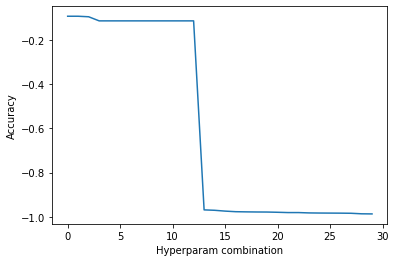

In [24]:
results['loss'].plot()
plt.ylabel('Accuracy')
plt.xlabel('Hyperparam combination')

# Evaluate the model

In [25]:
# load best model

model = load_model(path_best_model)

In [26]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 1s 9ms/step - loss: 0.0514 - accuracy: 0.9862


In [27]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.05139937251806259
accuracy 0.9861904978752136


## Confusion matrix

In [28]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

array([[412,   0,   0,   0,   0,   0,   4,   0,   4,   2],
       [  0, 469,   2,   0,   0,   0,   0,   1,   1,   0],
       [  1,   0, 404,   4,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1, 421,   0,   1,   0,   1,   1,   1],
       [  1,   3,   0,   0, 421,   0,   4,   0,   0,   0],
       [  0,   0,   0,   1,   0, 377,   2,   0,   2,   0],
       [  0,   0,   0,   0,   0,   1, 411,   0,   0,   0],
       [  0,   1,   4,   0,   0,   1,   0, 463,   0,   0],
       [  0,   1,   1,   0,   0,   1,   1,   0, 379,   1],
       [  1,   0,   0,   1,   6,   0,   0,   1,   0, 385]], dtype=int64)

Text(0.5, 13.421126458070283, 'Predicted label')

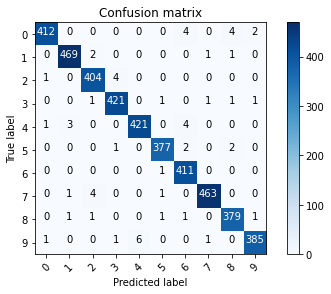

In [29]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here we can see that our CNN performs very well on all digits.